# Quantum Extreme Learning Machine 


### A simple task

Consider the following classical data points, which are classified into one of two classes. Our goal is to learn to perform this classification, not by memorizing every point but rather by learning the underlying rule, so we will able to classify new points too. Below this data is generated and you can see it ploted, with two different classes


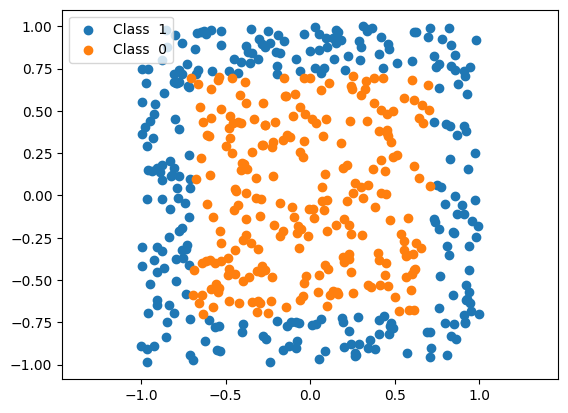

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Set random seed so results are repeatable
np.random.seed(2025)

## Underlying classification, outside of square or inside
def underlying_function(R: np.ndarray) -> float:
    return np.max(np.abs(R), axis=1) > 1/np.sqrt(2)


## Prepare random dataset
Nsamples = 500
R = 2*np.random.random((Nsamples,2)) - np.array([1,1])  # Data points, uniform in [-1,1]x[-1,1]

y = underlying_function(R)   # Classification

R_class1 = R[y]                    # Class +1: Outside of square
R_class0 = R[np.logical_not( y )]  # Class  0: Inside  of square

plt.axis('equal')
plt.scatter(R_class1[:,0], R_class1[:,1], label="Class  1")
plt.scatter(R_class0[:,0], R_class0[:,1], label="Class  0")
plt.legend(loc = "upper left")

The underlying function is simple: points inside the $\sqrt{2}$ square are in class 0 and points outside in class 1, but we must now try to learn this in a generic way, even if this is a simple case.
We will learn to classify points, by learning the underlying distribution, which you can see is $f(\vec{x}) = 0$, if $\vec{x} \in [-\frac{\sqrt{2}}{2}, \frac{\sqrt{2}}{2}] \times [-\frac{\sqrt{2}}{2}, \frac{\sqrt{2}}{2}] $; $\quad 1$ otherwise. To do this, you will create a Quantum Neural Network (QNN) and later you will train it on the data.

## CLASSICAL INPUTS

In [ ]:
from qiskit.circuit.library import YGate, UnitaryGate
from qiskit import QuantumCircuit

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService

Troterization of the Ising Model (prepare the processing of the QELM)

In [32]:


SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")


def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angles, rz_angles, num_cl_bits=0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angles[trotter_step], rz_angles[trotter_step], layer_barriers)
        if trotter_barriers:
            qc.barrier()
    
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angles_layer, rz_angles_layer, layer_barriers = False):
    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
        for i in range(qc.num_qubits):
            qc.rx(rx_angles_layer[i], i)
            qc.rz(rz_angles_layer[i], i)
    if layer_barriers:
        qc.barrier()



# Defining the encoding process and the the processing process of QELM

In [ ]:
## Your code here
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap     # Example featuremap/encoding
from qiskit.circuit.library import EfficientSU2, RealAmplitudes  # Example processing layer

# Example of parameters you may use. Default input. If using default, inputs are called x and trainable_parameters θ


# By default, you may use only 2 qubits, one for each coordinate





def encoding(NQUBITS, inputs: ParameterVector) -> QuantumCircuit:

    """Returns an encoder that will encode a point in space (x,y) into a quantum circuit.
    Args:
        inputs (ParameterVector): parameters corresponding to input (x, y) 
    Returns:
        encoding_circuit (QuantumCircuit): Returns a QuantumCircuit, which encodes the classical data into the circuit
    """
    # YOUR CODE HERE
    encoding_circuit = QuantumCircuit(NQUBITS)
    encoding_circuit.ry(2*inputs[0],0)
    encoding_circuit.ry(2*inputs[1],1)
    encoding_circuit.cz(0,1)
    for i in range(2, NQUBITS):
        encoding_circuit.h(i)
        if i>2:
            encoding_circuit.cz(i-1,i)
    encoding_circuit.barrier(label="Encoding Complete")
    return encoding_circuit



def processing( NQUBITS, num_trotter_steps, rx_angles, rz_angles) -> QuantumCircuit:
    """Returns a processing layer that will be trained to try to solve our problem

    Args:
        trainable_parameters (ParameterVector): parameters that will be trained to attempt to solve the problem

    Returns:
        processing_circuit (QuantumCircuit): Returns a QuantumCircuit that encodes the data into the circuit
    """
    # YOUR CODE HERE


    processing_circuit = QuantumCircuit(NQUBITS)
    if num_trotter_steps > 0:
        processing_circuit = generate_1d_tfim_circuit(NQUBITS, num_trotter_steps, rx_angles, rz_angles, trotter_barriers=True, layer_barriers=True)
        
            
    return processing_circuit



Here you may draw your encoding,

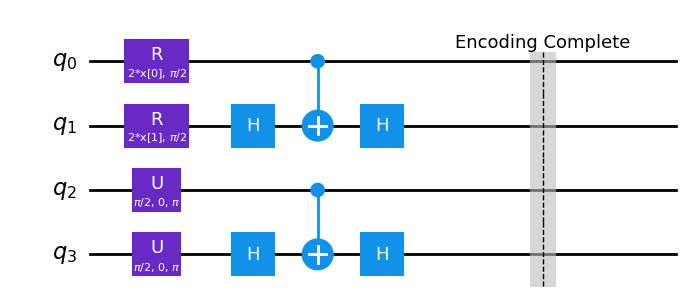

In [35]:
NQUBITS = 4
inputs = ParameterVector('x', 2)
encoding_circuit = encoding(NQUBITS, inputs)
encoding_circuit.decompose().draw(output='mpl', style='textbook')

processing

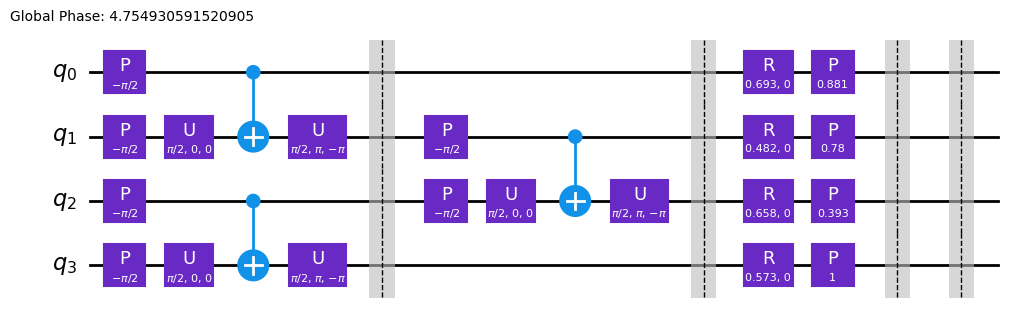

In [ ]:
Bx, Bz = 0.6, 0.9
num_trotter_steps = 1
rx_angles = np.random.normal(loc = Bx, scale = 0.2, size = (num_trotter_steps, NQUBITS))
rz_angles = np.random.normal(loc = Bz, scale = 0.2, size = (num_trotter_steps, NQUBITS))

processing_circuit = processing(NQUBITS, 1, rx_angles, rz_angles)
processing_circuit.decompose().draw(output='mpl', style='textbook')

Example of the troterization process

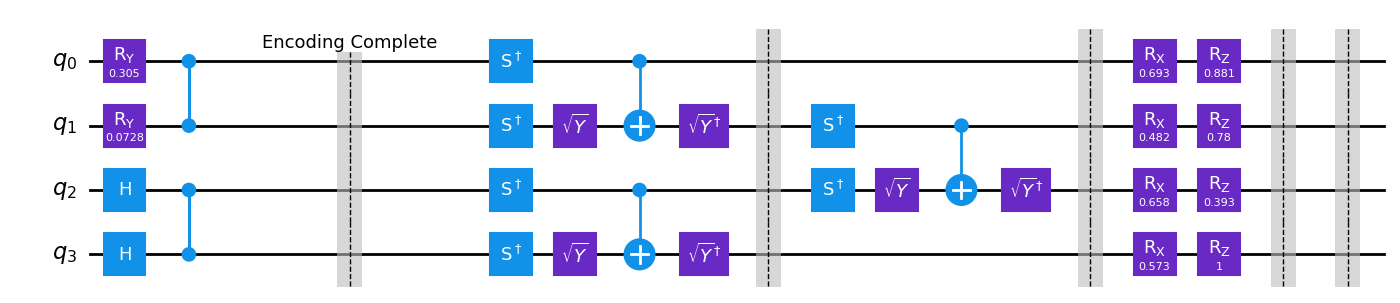

In [38]:
# Assign our parameters, may need to adapt
inputs = np.random.rand(2)
encoding_circuit.assign_parameters(inputs, inplace=True)
qnn_circuit = encoding_circuit.compose(processing_circuit)
    
qnn_circuit.draw(output='mpl', style='textbook')

In [55]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("Z"*NQUBITS)

Here we are defining the forward step (the quantum processing of the input's information)

In [66]:
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
# Assign our parameters, may need to adapt
NQUBITS = 4
def Observables_output(R: np.ndarray, NQUBITS: int, magnetic_field_x, magnetic_field_z, n_trotter_steps) -> np.ndarray:
    inputs = ParameterVector('x', 2)
    encoding_circuit = encoding(NQUBITS, inputs)
    processing_circuit = processing(NQUBITS, n_trotter_steps, magnetic_field_x, magnetic_field_z)
    observables = [SparsePauliOp("I" * i + "Z" + "I" * (NQUBITS - i - 1)) for i in range(NQUBITS)]

    X = np.zeros((R.shape[0], NQUBITS))

    for  i,inputs in enumerate(R):
        qnn_circuit = encoding_circuit.compose(processing_circuit)
        estimator = Estimator()
        # Package the inputs as (circuit, observable, parameter_values)
        pub = (qnn_circuit,  observables, inputs)

        # Run the job
        job = estimator.run([pub])
        result = job.result()
        X[i] = result[0].data.evs

    return X    



Here we prepare a the binary classification regression (we use an activation function in order to transform the outputs to probabilities of being 0 or 1)

In [6]:
def elm_fit(X, y, n_hidden=100, activation='sigmoid', random_state=42):

    n_samples, n_features = X.shape
    
    # Convert labels to -1 and 1
    y_transformed = 2 * y - 1
    y_transformed = y_transformed.reshape(-1, 1)
    
    # Randomly initialize input weights and bias
    input_weights = np.random.randn(n_features, n_hidden)
    bias = np.random.randn(n_hidden)
    
    # Calculate hidden layer output
    H = np.dot(X, input_weights) + bias
    
    # Apply activation function
    if activation == 'sigmoid':
        H = 1 / (1 + np.exp(-np.clip(H, -500, 500)))
    elif activation == 'tanh':
        H = np.tanh(H)
    elif activation == 'relu':
        H = np.maximum(0, H)
    
    # Calculate output weights using pseudoinverse (linear regression)
    output_weights = np.dot(np.linalg.pinv(H), y_transformed)
    
    # Return model parameters
    model = {
        'input_weights': input_weights,
        'bias': bias,
        'output_weights': output_weights,
        'activation': activation
    }
    
    return model

def elm_predict(X, model):
    # Extract model parameters
    input_weights = model['input_weights']
    bias = model['bias']
    output_weights = model['output_weights']
    activation = model['activation']
    
    # Calculate hidden layer output
    H = np.dot(X, input_weights) + bias
    
    # Apply activation function
    if activation == 'sigmoid':
        H = 1 / (1 + np.exp(-np.clip(H, -500, 500)))
    elif activation == 'tanh':
        H = np.tanh(H)
    elif activation == 'relu':
        H = np.maximum(0, H)
    
    # Calculate output
    y_pred = np.dot(H, output_weights)
    
    # Convert back to 0 and 1
    return (y_pred > 0).astype(int).ravel()

Here we train our QELM

In [14]:
NQUBITS = 4
Bx, Bz = 0.6, 0.9
num_trotter_steps = 1
rx_angles = np.random.normal(loc = Bx, scale = 0.2, size = (num_trotter_steps, NQUBITS))
rz_angles = np.random.normal(loc = Bz, scale = 0.2, size = (num_trotter_steps, NQUBITS))
X = Observables_output(R, NQUBITS, rx_angles, rz_angles, num_trotter_steps)
elm_model = elm_fit(X, y, n_hidden=NQUBITS, activation='sigmoid')

Here we test our QELM

In [ ]:
R_test = 2*np.random.random((100,2)) - np.array([1,1])  # Data points, uniform in [-1,1]x[-1,1]
X_test = Observables_output(R_test, NQUBITS, rx_angles, rz_angles, num_trotter_steps)
y_test = underlying_function(R_test)
y_pred = elm_predict(X_test, elm_model)
acc = (np.mean(y_pred == y_test))
print(f'accuracy ={acc}')

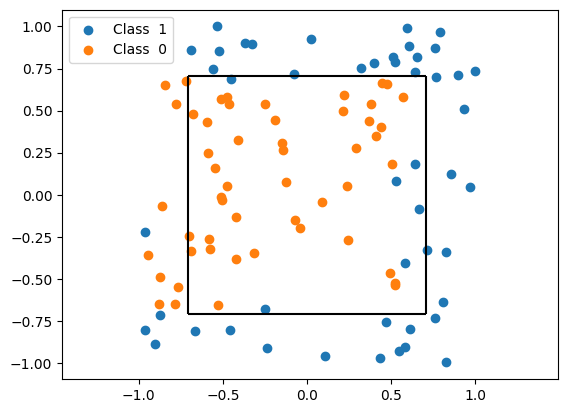

In [17]:
R_class1_test = R_test[y_pred==True]                    # Class +1: Outside of square
R_class0_test = R_test[y_pred==False]  # Class  0: Inside  of square



plt.axis('equal')
plt.scatter(R_class1_test[:,0], R_class1_test[:,1], label="Class  1")
plt.scatter(R_class0_test[:,0], R_class0_test[:,1], label="Class  0")
plt.hlines(1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2), colors='black')
plt.vlines(1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2), colors='black')
plt.hlines(-1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2), colors='black')
plt.vlines(-1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2), colors='black')
plt.legend(loc = "upper left")

Hyperparaters (magnetic field values) optimization

In [ ]:
matrix_acc = np.zeros((100,100))
NQUBITS = 4
num_trotter_steps = 1
np.random.seed(2025)
for bx in np.linspace(0, 1, 100):
    for bz in np.linspace(0, 1, 100):
        rx_angles = np.random.normal(loc = bx, scale = 0.2, size = (num_trotter_steps, NQUBITS))
        rz_angles = np.random.normal(loc = bz, scale = 0.2, size = (num_trotter_steps, NQUBITS))
        X = Observables_output(R, NQUBITS, rx_angles, rz_angles, num_trotter_steps)
        elm_model = elm_fit(X, y, n_hidden=NQUBITS, activation='sigmoid')

        R_test = 2*np.random.random((100,2)) - np.array([1,1])  # Data points, uniform in [-1,1]x[-1,1]
        X_test = Observables_output(R_test, NQUBITS, rx_angles, rz_angles, num_trotter_steps)
        y_test = underlying_function(R_test)
        y_pred = elm_predict(X_test, elm_model)
        acc = (np.mean(y_pred == y_test))
        matrix_acc[int(bx*9), int(bz*9)] = acc
np.save("accuracy_matrix_tfim.npy", matrix_acc)
plt.figure(figsize=(10, 6))

# Plot with log(RMSE)
im = plt.imshow(
    matrix_acc.T,
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Colorbar with LaTeX label
cbar = plt.colorbar(im)
cbar.set_label(r'$\log(\mathrm{RMSE})$', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axis labels with LaTeX variables
plt.xlabel(rf'Bx$', fontsize=12)
plt.ylabel(rf'Bz$', fontsize=12)
plt.grid(False)

# Ticks styling
plt.tick_params(axis='both', which='major', labelsize=10)

# Save high-resolution
plt.savefig(
   'BxBz.png',
    dpi=300,
    bbox_inches='tight'
)
plt.close()

## 2. Putting more quantum in Quantum Machine Learning

Right now you have worked on a classical classification problem using quantum computers. Now we switch to the main challenge.

Your task will be to train a quantum machine learning model to classify which phase of matter corresponds to each input quantum state.

We are going to study now the XY model on a periodic chain, with a hamiltonian representing its energy and properties given by

$$H = -\sum^N_{j=1} \left [ \left(\frac{1+\gamma}{2}\right) X_j X_{j+1} + \left(\frac{1-\gamma}{2}\right) Y_j Y_{j+1}  + h Z_j \right],$$

with $\sigma_{N+1}=\sigma_1$.
It has the following simple phase diagram, where we will focus on the $h,\gamma>0$ region, with phase transitions at $h = 1$ and at the circular boundary $\gamma^2 + h^2 = 1$:

![image.png](attachment:image.png)

### 2.1 Implement the hamiltonian


First you must implement the hamiltonian in Qiskit

In [19]:
from qiskit.quantum_info import SparsePauliOp
# Code here

def XY_hamiltonian(gamma: float, h: float, Nsites: int) -> SparsePauliOp:
    """Returns the XY Hamiltonian as a SparsePauliOp.

    H = - sum_j [ (1+gamma)/2 * X_j X_{j+1} + (1-gamma)/2 * Y_j Y_{j+1} + h * Z_j ]
    periodic boundary conditions: site N -> site 0

    Note: Pauli string ordering follows Qiskit's convention for labels (leftmost char = qubit 0).
    """
    pauli_labels = []
    coeffs = []

    # coefficients for XX and YY
    coeff_XX = - (1 + gamma) / 2.0
    coeff_YY = - (1 - gamma) / 2.0
    coeff_Z  = - h

    for j in range(Nsites):
        jp1 = (j + 1) % Nsites  # periodic next index

        # Build X_j X_{j+1} string
        xs = ['I'] * Nsites
        xs[j] = 'X'
        xs[jp1] = 'X'
        pauli_labels.append(''.join(xs))
        coeffs.append(coeff_XX)

        # Build Y_j Y_{j+1} string
        ys = ['I'] * Nsites
        ys[j] = 'Y'
        ys[jp1] = 'Y'
        pauli_labels.append(''.join(ys))
        coeffs.append(coeff_YY)

        # Build Z_j term
        zs = ['I'] * Nsites
        zs[j] = 'Z'
        pauli_labels.append(''.join(zs))
        coeffs.append(coeff_Z)

    # Create SparsePauliOp from list of (label, coeff)
    # It's fine if some labels repeat; SparsePauliOp will internally combine.
    hamiltonian = SparsePauliOp.from_list(list(zip(pauli_labels, coeffs)))
    return hamiltonian

### 2.2 Solve it classically

Create a classical method to find the ground states of the hamiltonian
> hint: use libraries such as eigsh to diagonalise the hamiltonian with `.to_matrix()`

The steps are similar to the case before, but now the inputs do not need to be directly embeded into the quantum computer as they are already quantum states. You can use `.prepare_state()`. You can start simple, with N=6 qubits.

In [ ]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh 


def XY_ground_state(gamma: float, h: float, Nsites: int) -> np.ndarray:
    """Returns the ground state (statevector) of the XY Hamiltonian for given params.

    Uses an iterative sparse eigensolver (eigsh) on the dense matrix (converted to sparse csr).
    For moderate N (N <= 12-ish) this is feasible; for larger N you need specialised many-body methods.
    """
    H_op = XY_hamiltonian(gamma, h, Nsites)

    # Convert to dense matrix (for small N this is okay). H_op.to_matrix() returns a numpy array.
    H_mat = H_op.to_matrix()  # shape (2**N, 2**N), dtype=complex

    # Use sparse eigensolver for the lowest eigenvalue/vector (k=1, which='SA' = smallest algebraic)
    try:
        # Convert to CSR for eigsh
        H_sparse = csr_matrix(H_mat)
        eigvals, eigvecs = eigsh(H_sparse, k=1, which='SA')
        ground_energy = eigvals[0]
        ground_state = eigvecs[:, 0]
    except Exception:
        # Fallback: dense diagonalization (guaranteed but slower)
        evals, evecs = np.linalg.eigh(H_mat)
        ground_energy = evals[0]
        ground_state = evecs[:, 0]

    # Normalize (eigsh usually returns normalized vectors, but ensure it)
    ground_state = ground_state / np.linalg.norm(ground_state)

    # Return the statevector as a complex numpy array
    return ground_state, ground_energy


# ejemplo
gamma = 0.3
h = 0.9
Nsites = 6

psi_gs, E_gs = XY_ground_state(gamma, h, Nsites)
print("E_ground =", E_gs)
print("dim statevector =", psi_gs.shape)



E_ground = -5.801745374596569
dim statevector = (64,)


# Preparig QLM

In [ ]:
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation
from qiskit_aer import AerSimulator
from qiskit import transpile

def encoder(NQUBITS, n_state_qubits, gamma: float, h: float) -> QuantumCircuit:
    psi_gs, E_gs = XY_ground_state(gamma, h, n_state_qubits)
    qc = QuantumCircuit(NQUBITS)
    prep_gate = StatePreparation(psi_gs)
    qc.append(prep_gate, range(n_state_qubits))
    for i in range(n_state_qubits-1):
        qc.cz(i,i+1)
    for i in range(n_state_qubits, NQUBITS):
        qc.h(i)
        if i>n_state_qubits:
            qc.cz(i-1,i)
    qc.barrier(label="Encoding Complete")
    # Transpile to basis gates compatible with Aer
    backend = AerSimulator()
    qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
    return qc_transpiled



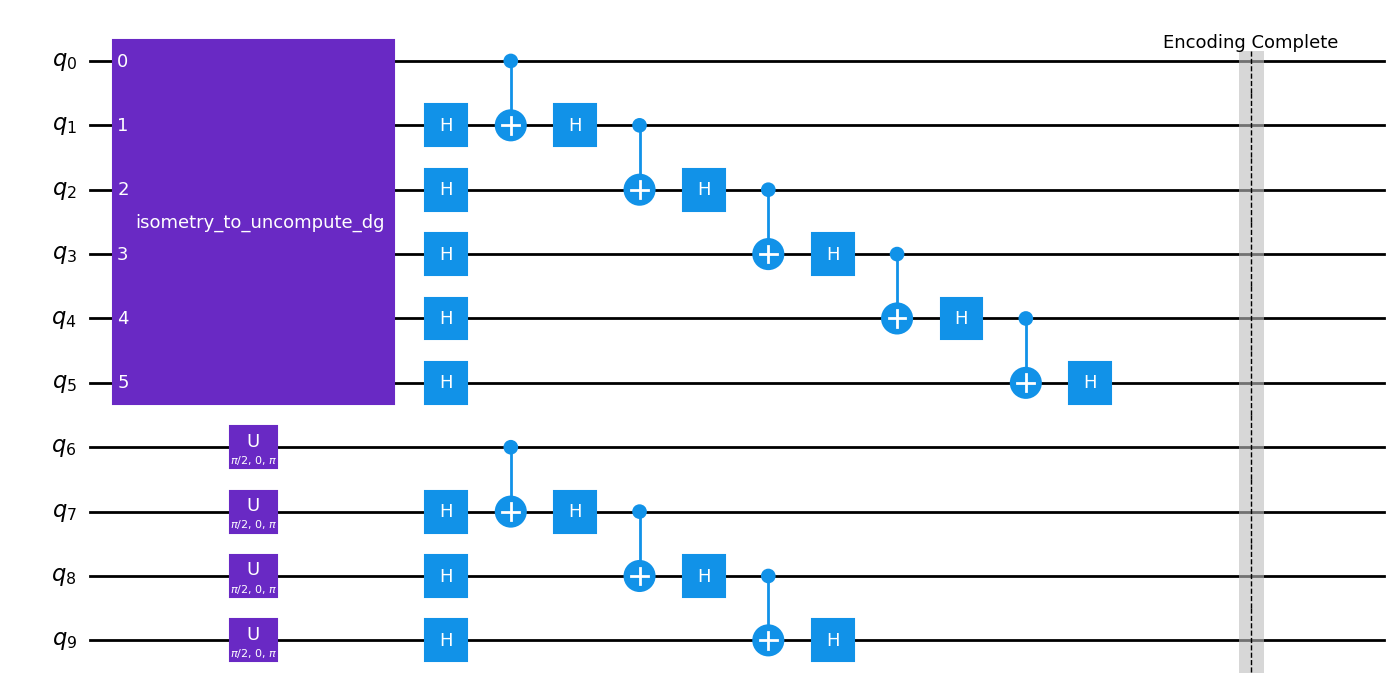

In [41]:
NQUBITS = 10
n_state_qubits = 6
gamma = 0.3
h = 0.9
encoding_circuit = encoder(NQUBITS, n_state_qubits, gamma, h)
encoding_circuit.decompose().draw(output='mpl', style='textbook')

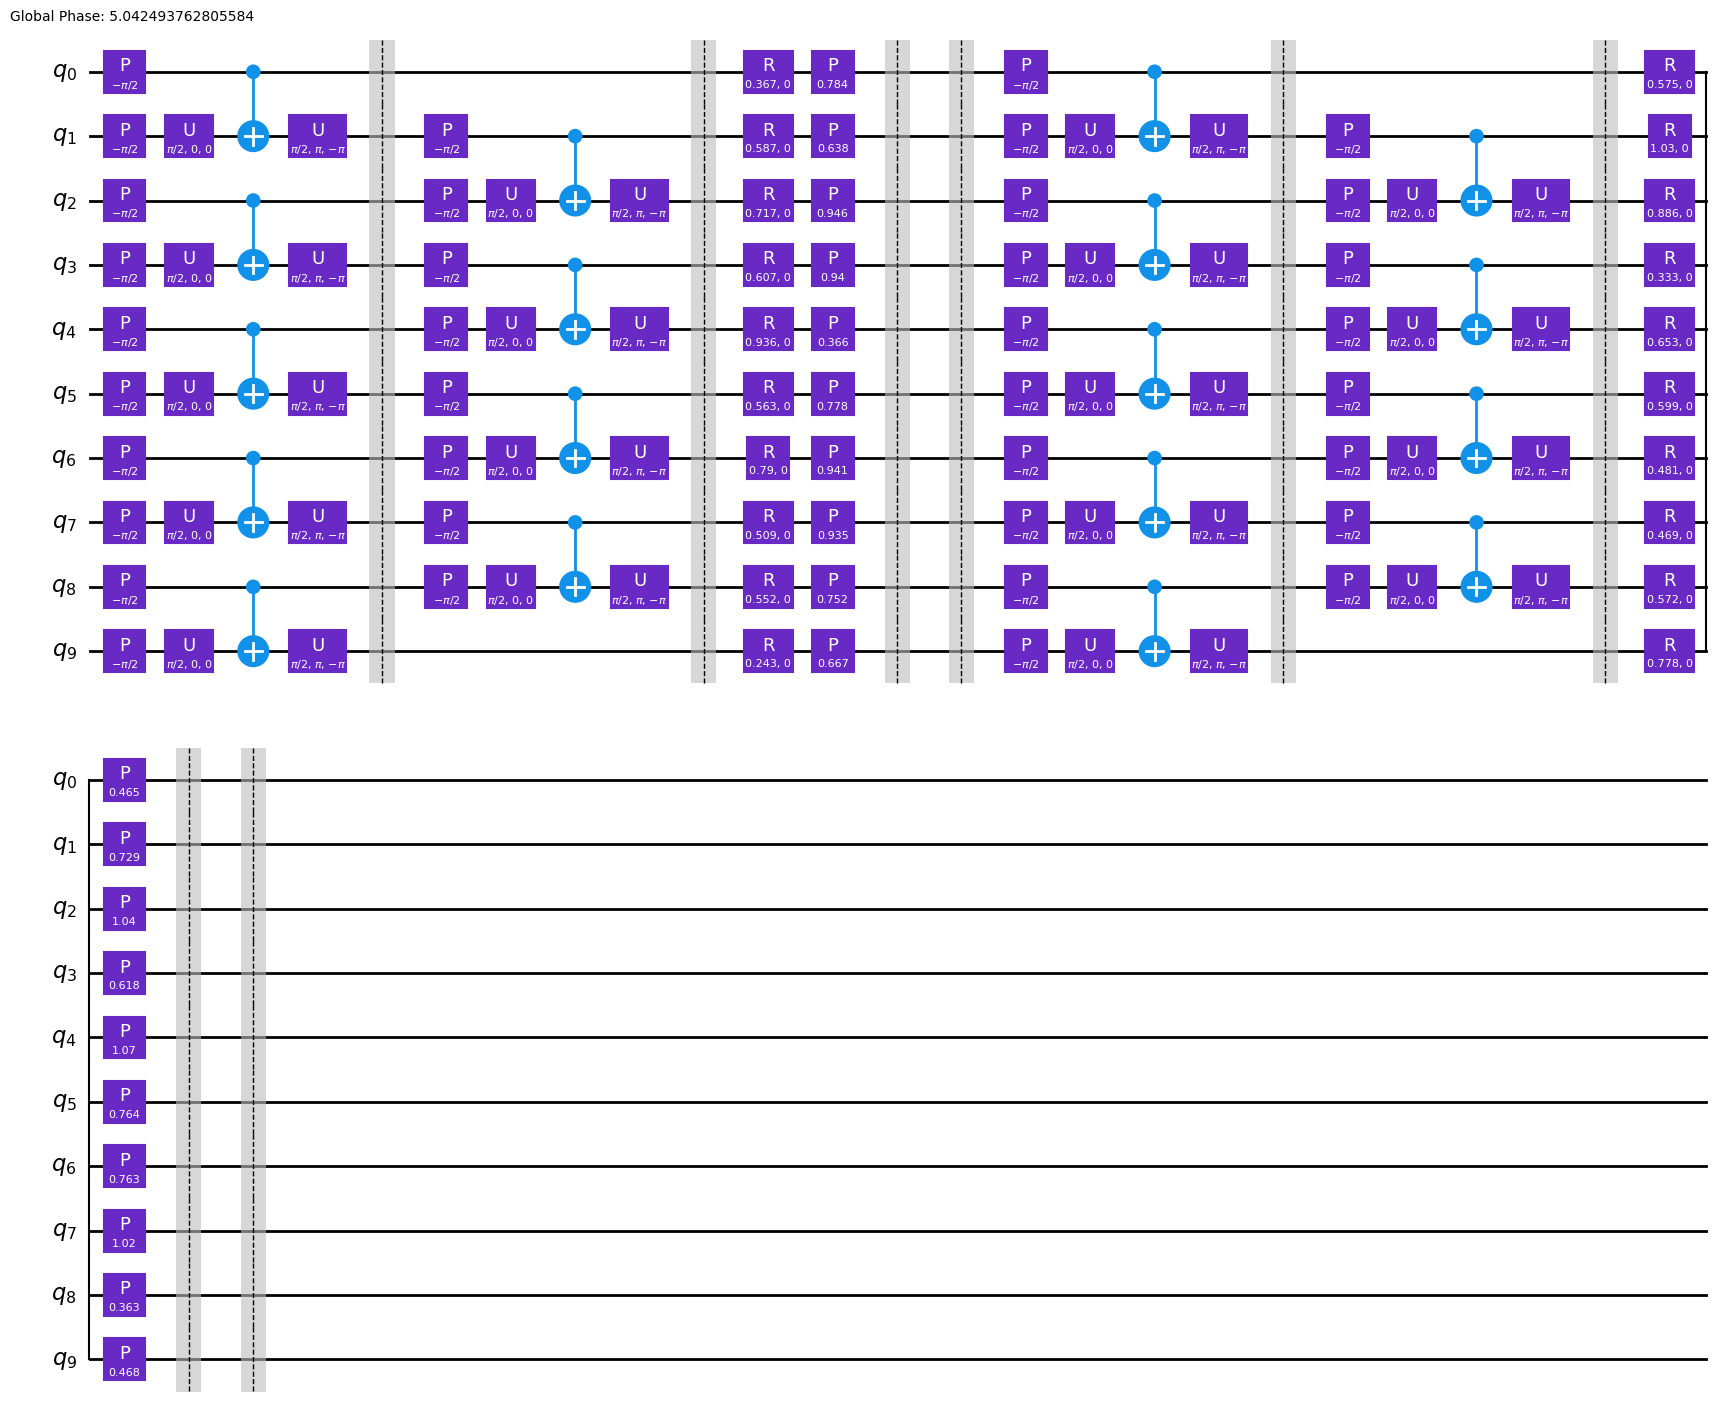

In [ ]:
rx_angles = np.random.normal(loc = Bx, scale = 0.2, size = (num_trotter_steps, NQUBITS))
rz_angles = np.random.normal(loc = Bz, scale = 0.2, size = (num_trotter_steps, NQUBITS))

NQUIBITS = 10
processing_circuit = processing(NQUBITS, 1, rx_angles, rz_angles)
processing_circuit.decompose().draw(output='mpl', style='textbook')


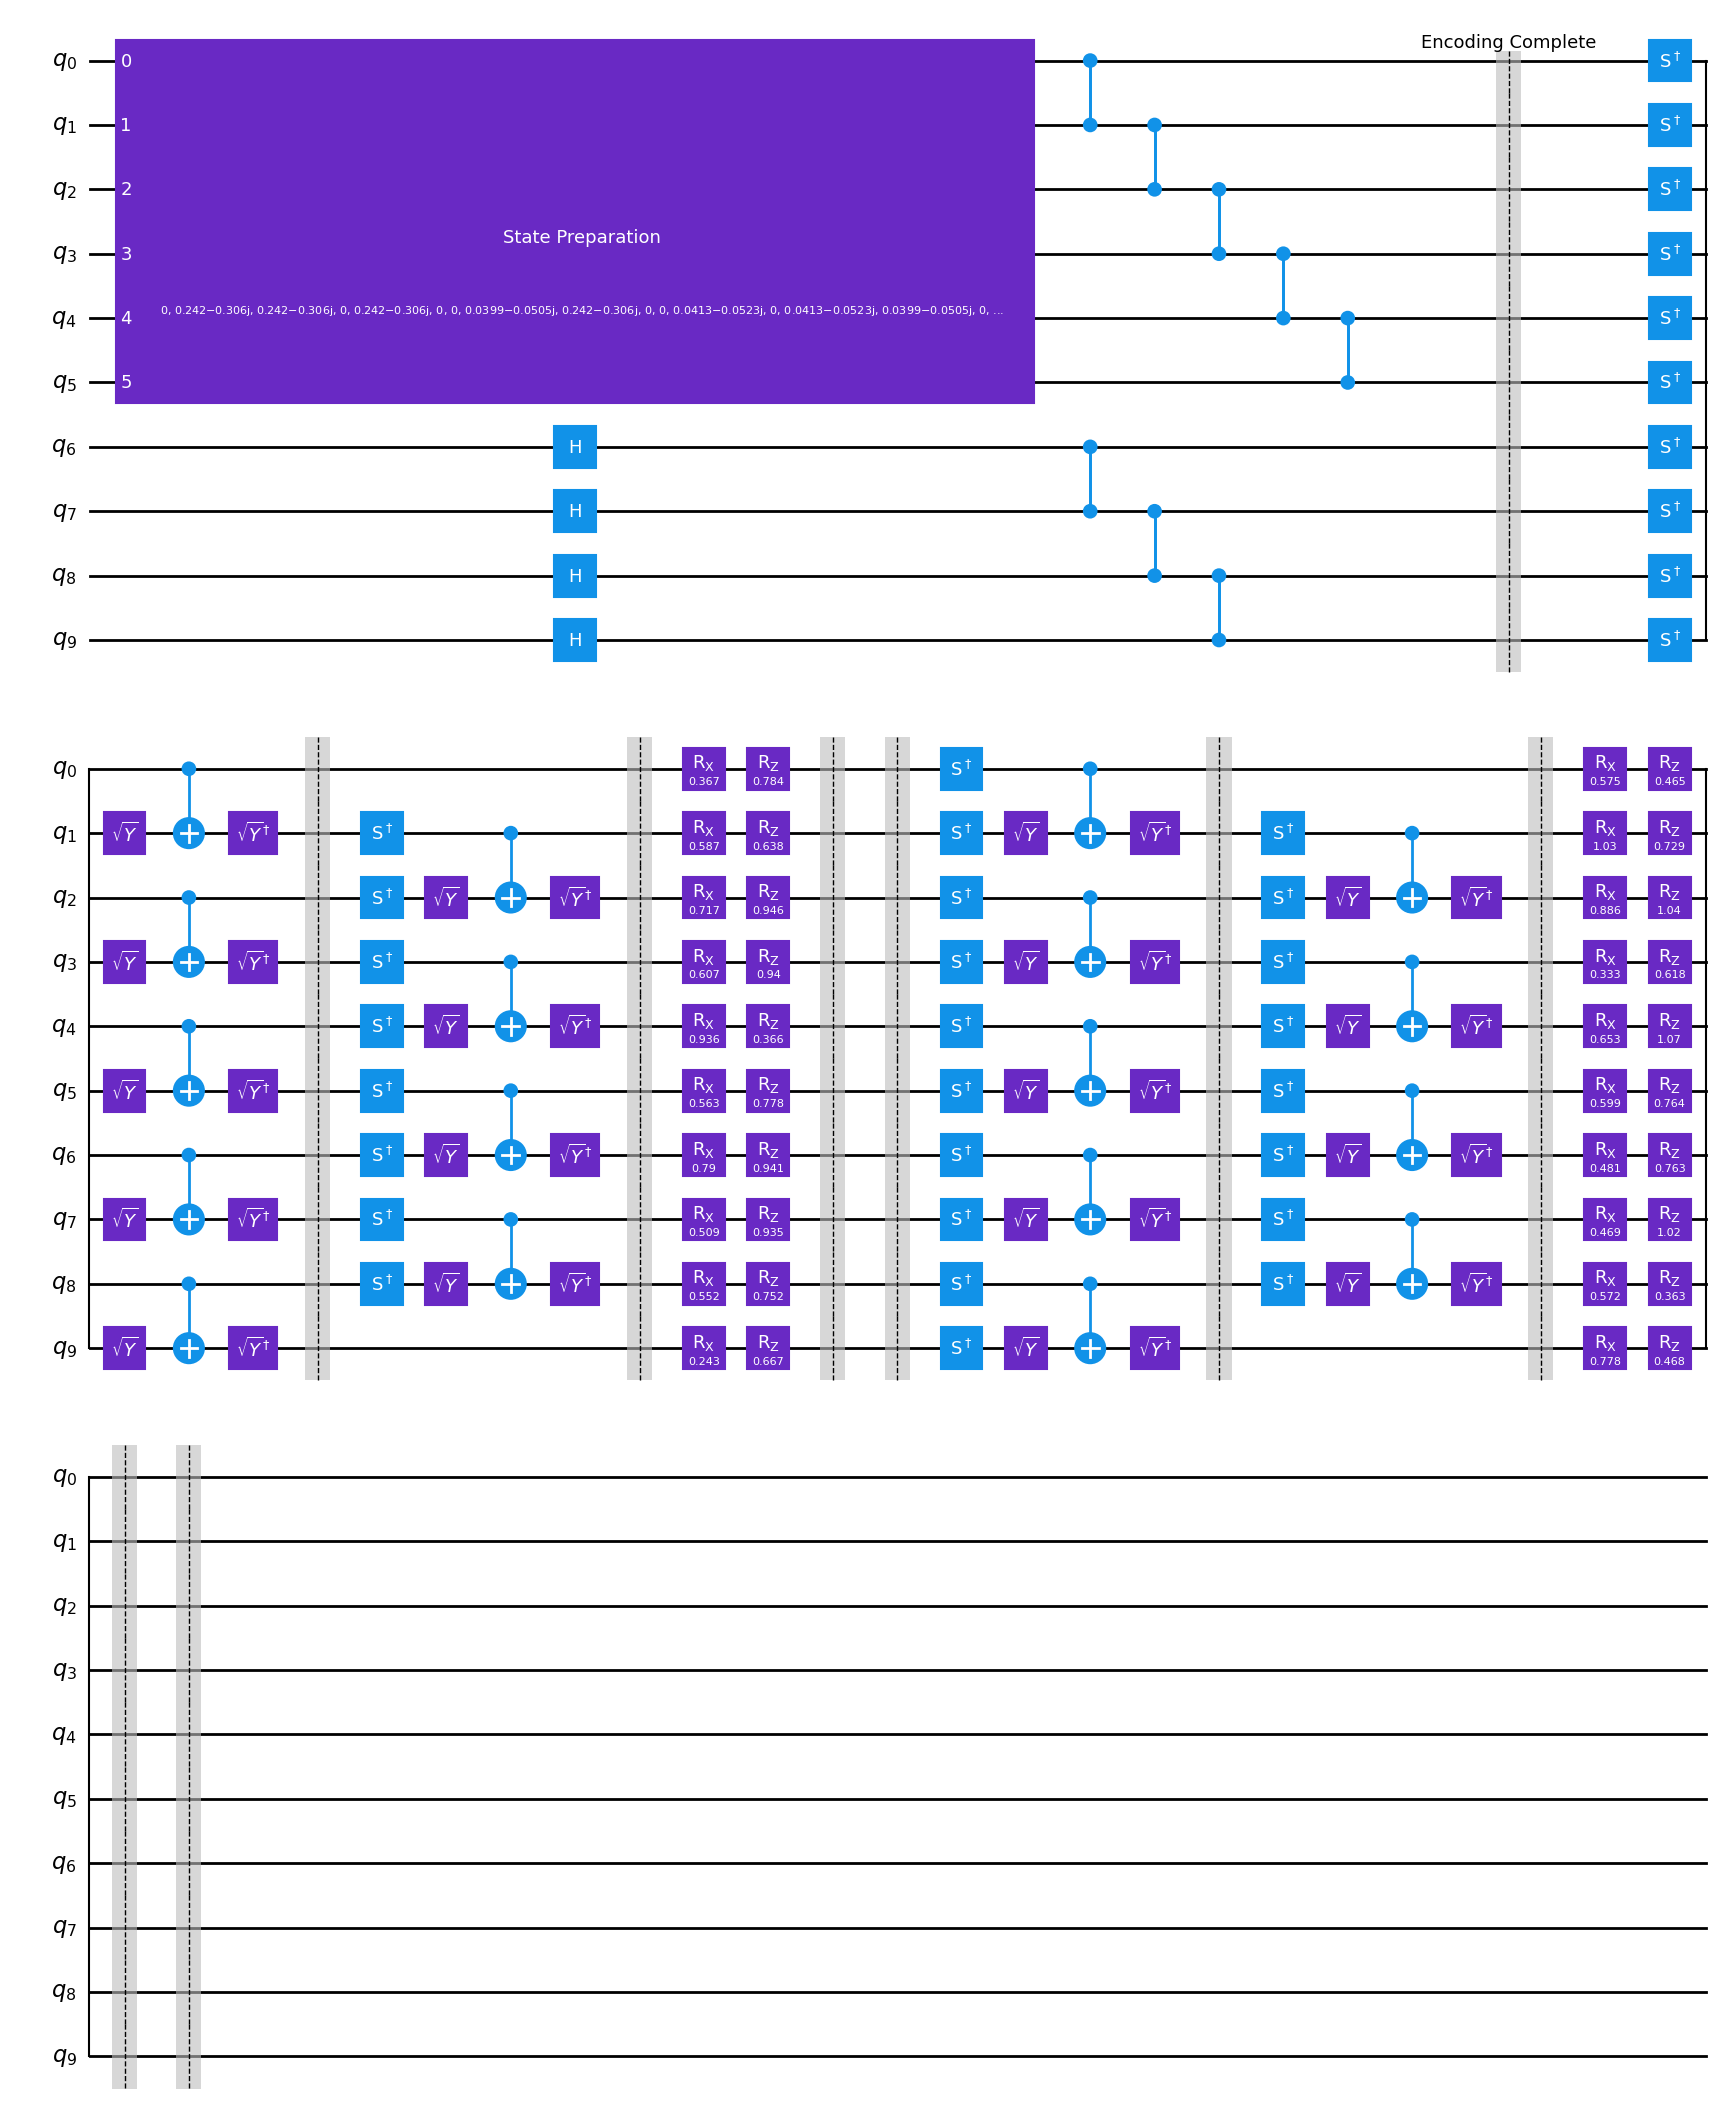

In [148]:
qnn_circuit = encoding_circuit.compose(processing_circuit)
qnn_circuit.draw(output='mpl', style='textbook')

In [140]:
def Observables_output_Ising(R, n_state_qubits: int, NQUBITS: int, magnetic_field_x, magnetic_field_z, n_trotter_steps) -> np.ndarray:
   
    
    processing_circuit = processing(NQUBITS, n_trotter_steps, magnetic_field_x, magnetic_field_z)
    observables = [SparsePauliOp("I" * i + "Z" + "I" * (NQUBITS - i - 1)) for i in range(NQUBITS)]

    X = np.zeros((R.shape[0], NQUBITS))

    for  i,inputs in enumerate(R):
        encoding_circuit = encoder(NQUBITS, n_state_qubits, inputs[0], inputs[1])
        qnn_circuit = encoding_circuit.compose(processing_circuit)
        estimator = Estimator()
        # Package the inputs as (circuit, observable, parameter_values)
        pub = (qnn_circuit,  observables)

        # Run the job
        job = estimator.run([pub])
        result = job.result()
        X[i] = result[0].data.evs

    return X 

# Creatig Datasets and Training 

In [141]:
def y_underlying_Ising(gamma, h):
    r = h**2 + gamma**2
    if r < 1:
        return np.array([1,0,0])
    elif h<1:
        return np.array([0,1,0])
    else:
        return np.array([0,0,1])

parameters = np.random.rand(500,2)*2
NQUBITS = 10
n_state_qubits = 6
num_trotter_steps = 2
Bx, Bz = 0.6, 0.8
rx_angles = np.random.normal(loc = Bx, scale = 0.2, size = (num_trotter_steps, NQUBITS))
rz_angles = np.random.normal(loc = Bz, scale = 0.2, size = (num_trotter_steps, NQUBITS))
y = np.array([y_underlying_Ising(gamma, h) for h,gamma in parameters])
X = Observables_output_Ising(parameters, n_state_qubits, NQUBITS, rx_angles, rz_angles, num_trotter_steps)
y_train, X_train = y[:400], X[:400]
y_test, X_test = y[400:], X[400:]





# Testing

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.06631184340718822


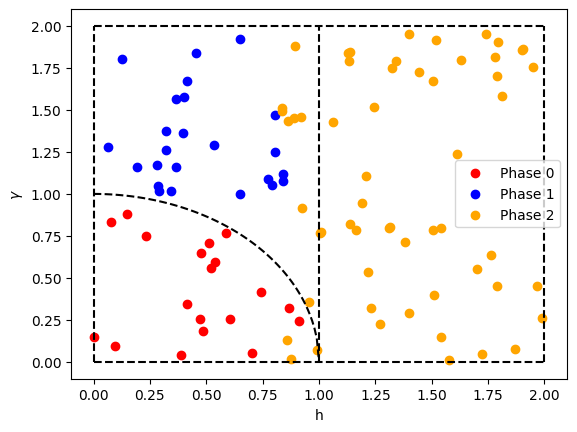

In [ ]:
phase = [int(np.where(y_pred[i]==max(y_pred[i]))[0][0]) for i in range(len(y_pred))]
R_0 = parameters[400:][np.array(phase)==0]
R_1 = parameters[400:][np.array(phase)==1]
R_2 = parameters[400:][np.array(phase)==2]

plt.scatter(R_0[:,0], R_0[:,1], label="Phase 0", color='red')
plt.scatter(R_1[:,0], R_1[:,1], label="Phase 1", color='blue')
plt.scatter(R_2[:,0], R_2[:,1], label="Phase 2", color='orange')
plt.vlines(1, 0, 2, colors='black', linestyles='dashed')
x = np.linspace(0,1,100)
y = np.sqrt(1 - x**2)
plt.plot(x, y, color='black', linestyle='dashed')
plt.hlines(2, 0, 2, colors='black', linestyles='dashed')
plt.hlines(0, 0, 2, colors='black', linestyles='dashed')
plt.vlines(0, 0, 2, colors='black', linestyles='dashed')
plt.vlines(2, 0, 2, colors='black', linestyles='dashed')
plt.xlabel('h')
plt.ylabel(r'$\gamma$')
plt.legend()
plt.show()



In [ ]:
def classify_params_ising(gamma, h):
    r = h**2 + gamma**2
    if r < 1:
        return 0
    elif h<1:
        return 1
    else:
        return 2

#accuracy calculation
correct = 0
theoretical_phase = [classify_params_ising(parameters[i+400][1], parameters[i+400][0]) for i in range(len(parameters[400:]))]

for i in range(len(theoretical_phase)):
    if theoretical_phase[i] == phase[i]:
        correct += 1
accuracy = correct / len(theoretical_phase)
print(f'Accuracy: {accuracy*100:.2f}%')
